# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from matplotlib import pyplot
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, TimeDistributed, Flatten

# Enviorment

In [2]:
class TradeEnv:
    
    def __init__(self, data, volume = 0.1, spread = 15, initial_investment = 0):
        
        self.currency_data = data
        self.n_step = self.currency_data.shape[0]
        self.n_indicators = len(self.currency_data[0][1])

        self.volume = volume
        self.spread = spread
        self.initial_investment = initial_investment
        
        # Donde estamos en el tiempo
        self.cur_step = None
        # Tenemos o no ordenes abiertas. 1 si tengo una orden abierta, 0 sino
        self.order_opened = None
        # Precio actual
        self.currency_price = None
        # Estado de mi posición actual
        self.currency_position = None
        # Dinero actual
        self.cash_in_hand = None
        
        # Listado de las acciones
        # 0 = BUY
        # 1 = SELL
        # 2 = NONE
        self.action_list = [0,1,2]
        self.action_size = len(self.action_list)
        
        # Dimension de mi state en base al cual voy a entrenar
        # Va a ser igual a mis indicadores + bool si orden es SELL + bool si orden es BUY + el estado de mi orden.
        self.state_dim = self.n_indicators + 3

        # Precio al cual opere y tipo de operacion y si esta abierta o no
        self.position_open_price = None
        self.position_type = None
        self.position_open = False
        self.open_action = 2
        
        self.reset()
        
    def reset(self):
        
        # Inicializo valores
        self.cur_step = 0
        self.order_opened = 0
        self.current_money = self.initial_investment
        self.indicators = self.currency_data[self.cur_step][1]
        self.currency_price = self.currency_data[self.cur_step][0]
        
        # Status de trades abiertos
        self.position_open_price = None
        self.position_type = None
        self.position_open = False
        
        return self._get_obs()
    
    # Obtiene mi interacción actual con el mercado
    # Va a ser los parametros de state en base a los cuales vamos a entrenar
    def _get_obs(self):

        obs = np.empty(self.state_dim)
        obs[:self.n_indicators] = self.indicators
        if self.position_open:
            if self.position_type == 0:
                obs[-3] = 0 # sell state
                obs[-2] = 1 # buy state
                obs[-1] = self.position_open_price - self.currency_price - (self.spread / 100000)
            else:
                obs[-3] = 1 # sell state
                obs[-2] = 0 # buy state
                obs[-1] = self.currency_price - self.position_open_price - (self.spread / 100000)  
        else:
            obs[-3] = 0 # sell state
            obs[-2] = 0 # buy state
            obs[-1] = 0
        
        return obs
    
    # Mi valor actual en dinero
    def _get_val(self):
        
        # Si no tengo currency position voy a retornar 0
        if not self.position_open:
            return self.current_money
        else:
            return (self.currency_position * 10000 * self.volume) + self.current_money
    
    def _trade(self, action):
        
        if action == 0:
            self._open_position(0)
        elif action == 1:
            self._open_position(1)
        elif action == 2:
            self._close_position()
    
    def _open_position(self, action):
        
        # Si tengo una posición abierta y es distina a la que quiero abrir la cierro
        if self.position_open:
            if self.open_action != action:
                
                self._close_position()
                
                self.currency_position = -1 * (self.spread / 100000)
                self.position_open_price = self.currency_price
                self.position_type = action
                self.position_open = True
        
        else:

            self.currency_position = -1 * (self.spread / 100000)
            self.position_open_price = self.currency_price
            self.position_type = action
            self.position_open = True
        
    
    def _close_position(self):
        
        # Cierro posición solo si hay posición para cerrar
        if self.position_open:
            self.current_money = self._get_val()
            self.position_open_price = None
            self.position_type = None
            self.position_open = False
        
    def step(self, action):
        # check accion este en el action space
        assert action in self.action_list
    
        # get current value before performing the action
        prev_val = self._get_val()
        
        # Determinando el tipo de posición que tengo actualmente
        buy, sell = self._get_obs()[-3:-1]

        if buy == 1:
            self.open_action = 0
        elif sell == 1:
            self.open_action = 1
        else:
            self.open_action = 2

        # update price, i.e. go to the next day
        self.cur_step += 1
        self.indicators = self.currency_data[self.cur_step][1]
        self.currency_price = self.currency_data[self.cur_step][0]
        
        # perform the trade
        self._trade(action)
        
        # Update position after taking action
        self.currency_position = self._get_obs()[-1]
    
        # get the new value after taking the action
        cur_val = self._get_val()
    
        # reward is the increase in porfolio value
        reward = cur_val - prev_val
    
        # done if we have run out of data
        done = self.cur_step == self.n_step - 1
    
        # store the current value of the portfolio here
        info = {'cur_val': cur_val}
        
        # conform to the Gym API
        return self._get_obs(), reward, done, info

# Load Data

In [3]:
# load data
data_raw = pd.read_csv('inputs/EURUSD1.csv')

# Feature Engineering

In [4]:
def get_hour_dataframe(data):

    # Get dataframe
    df_data_raw = pd.DataFrame(data.values, columns = ['Date','Hour','Open','High','Low','Close','Volume'])

    # Create DateTime date - hour index value
    df_data_raw['DateTime'] = df_data_raw['Date'] + ' ' + df_data_raw['Hour'].astype(str).str[:2]

    # Creo lista de todos mis indices por hora
    dt_values = df_data_raw['DateTime'].unique()
    
    # Seteo mi variable DateTime como indice
    df_data_raw.set_index(['DateTime'], inplace = True)

    X = []

    for dt_value in dt_values:

        df_hour = df_data_raw.loc[dt_value]

        if isinstance(df_hour, pd.core.frame.DataFrame):
        
            open_price = df_hour.sort_values(by = 'Hour')['Open'][0]
            close_price = df_hour.sort_values(by = 'Hour')['Close'][0]

            max_open_price = df_hour['Open'].max()
            max_close_price = df_hour['Close'].max()
            max_price = max([max_open_price, max_close_price])

            min_open_price = df_hour['Open'].min()
            min_close_price = df_hour['Close'].min()
            min_price = min([min_open_price, min_close_price])

            volume = df_hour['Volume'].sum()

            minutes = df_hour['Hour'].count()

        else:

            open_price = df_hour['Open']
            close_price = df_hour['Close']

            max_open_price = df_hour['Open']
            max_close_price = df_hour['Close']
            max_price = max([max_open_price, max_close_price])

            min_open_price = df_hour['Open']
            min_close_price = df_hour['Close']
            min_price = min([min_open_price, min_close_price])

            volume = df_hour['Volume']

            minutes = 1

        x = []
        x.append(dt_value)
        x.append(open_price)
        x.append(max_price)
        x.append(min_price)
        x.append(close_price)
        x.append(volume)
        x.append(minutes)

        X.append(x)

    df = pd.DataFrame(X,columns = ['DateTime','Open','High','Low','Close','Volume','Minutes'])

    df['DateTime'] = pd.to_datetime(df['DateTime'], format = '%Y.%m.%d %H')

    return df

In [5]:
# Obtención de nuestro features
df = get_hour_dataframe(data_raw)

# Vamos a usar todo 2021 y 2021 hasta junio, y usar los restantes meses del año para testear al agente
df = df[df['Minutes'] != 1 ]

df = df[(df['DateTime'] >= '2020-01-01 00:00:00') & (df['DateTime'] <= '2021-05-31 23:00:00') ].reset_index().drop('index',axis = 1)

<AxesSubplot:xlabel='DateTime', ylabel='Open'>

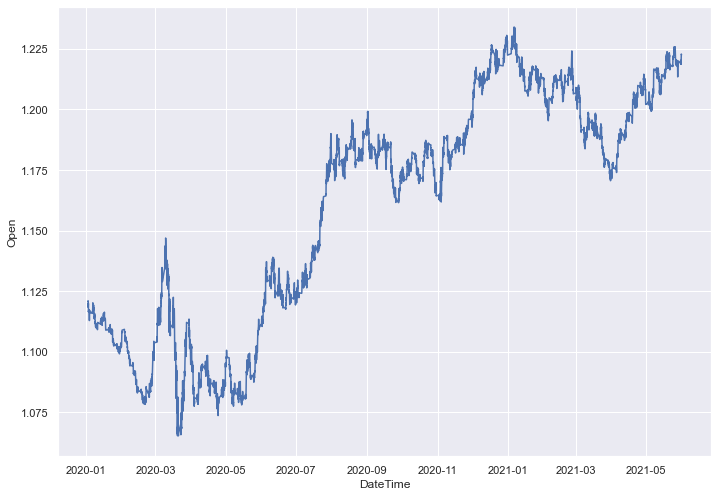

In [6]:
sns.lineplot(data=df, x="DateTime", y="Open")

In [9]:
def get_last_n(df_raw, n):

    close_data = df_raw['Close']
    open_data = df_raw['Open']

    X = []
    
    for i in range(len(close_data)):
        if i > n:
            x = []
            x.append(close_data[i])
            x.append(close_data[ : i - 1][-n:])
            X.append(x)

    return np.asarray(X)

In [8]:
data = get_last_n(df, 20)

# Setup

In [9]:
# episodios a jugar
episodes = 1000

gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = ( epsilon_max - epsilon_min )  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer

env = TradeEnv(data)

# Model

In [10]:
def create_q_model(input_shape, num_actions):

    model = Sequential()
    model.add(Dense(100, input_shape = input_shape))
    model.add(Dense(100))
    model.add(Dense(75))
    model.add(Dense(75))
    model.add(Dense(50))
    model.add(Dense(num_actions))

    return model

In [11]:
model = create_q_model((env._get_obs().shape[0],), env.action_size)

model_target = create_q_model((env._get_obs().shape[0],), env.action_size)

# Train

In [12]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
# Number of steps for exploration
epsilon_greedy_steps = 8000000
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 10000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 1000

# Using huber loss for stability
loss_function = keras.losses.Huber()

# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

In [13]:
for episode in range(episodes):

    state = np.array(env.reset()).reshape((1, env._get_obs().shape[0]))

    episode_reward = 0

    for step in range(env.n_step):
    
        if np.random.rand() <= epsilon:
            action = np.random.choice(env.action_size)
        else:
            action = np.argmax(model.predict(state)[0])

        # epsilon update
        epsilon -= epsilon_interval / epsilon_greedy_steps
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next).reshape((1, env._get_obs().shape[0]))

        episode_reward += reward  

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth step and once batch size is over 32
        if step % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample.reshape((state_next_sample.shape[0],state_next_sample.shape[2])))
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, env.action_size)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample.reshape((state_sample.shape[0],state_sample.shape[2])))

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if step % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, step {}"
            print(template.format(running_reward, episode, step))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

running reward: 0.00 at episode 0, step 0
running reward: 0.00 at episode 0, step 1000
running reward: 0.00 at episode 0, step 2000
running reward: 0.00 at episode 0, step 3000
running reward: 0.00 at episode 0, step 4000
running reward: 0.00 at episode 0, step 5000
running reward: 0.00 at episode 0, step 6000
running reward: 0.00 at episode 0, step 7000
running reward: 0.00 at episode 0, step 8000
running reward: -586.22 at episode 1, step 0
running reward: -586.22 at episode 1, step 1000
running reward: -586.22 at episode 1, step 2000
running reward: -586.22 at episode 1, step 3000
running reward: -586.22 at episode 1, step 4000
running reward: -586.22 at episode 1, step 5000
running reward: -586.22 at episode 1, step 6000
running reward: -586.22 at episode 1, step 7000
running reward: -586.22 at episode 1, step 8000
running reward: -569.11 at episode 2, step 0
running reward: -569.11 at episode 2, step 1000
running reward: -569.11 at episode 2, step 2000
running reward: -569.11 at e

running reward: -575.09 at episode 19, step 0
running reward: -575.09 at episode 19, step 1000
running reward: -575.09 at episode 19, step 2000
running reward: -575.09 at episode 19, step 3000
running reward: -575.09 at episode 19, step 4000
running reward: -575.09 at episode 19, step 5000
running reward: -575.09 at episode 19, step 6000
running reward: -575.09 at episode 19, step 7000
running reward: -575.09 at episode 19, step 8000
running reward: -574.16 at episode 20, step 0
running reward: -574.16 at episode 20, step 1000
running reward: -574.16 at episode 20, step 2000
running reward: -574.16 at episode 20, step 3000
running reward: -574.16 at episode 20, step 4000
running reward: -574.16 at episode 20, step 5000
running reward: -574.16 at episode 20, step 6000
running reward: -574.16 at episode 20, step 7000
running reward: -574.16 at episode 20, step 8000
running reward: -573.10 at episode 21, step 0
running reward: -573.10 at episode 21, step 1000
running reward: -573.10 at ep

running reward: -571.37 at episode 37, step 7000
running reward: -571.37 at episode 37, step 8000
running reward: -571.13 at episode 38, step 0
running reward: -571.13 at episode 38, step 1000
running reward: -571.13 at episode 38, step 2000
running reward: -571.13 at episode 38, step 3000
running reward: -571.13 at episode 38, step 4000
running reward: -571.13 at episode 38, step 5000
running reward: -571.13 at episode 38, step 6000
running reward: -571.13 at episode 38, step 7000
running reward: -571.13 at episode 38, step 8000
running reward: -572.66 at episode 39, step 0
running reward: -572.66 at episode 39, step 1000
running reward: -572.66 at episode 39, step 2000
running reward: -572.66 at episode 39, step 3000
running reward: -572.66 at episode 39, step 4000
running reward: -572.66 at episode 39, step 5000
running reward: -572.66 at episode 39, step 6000
running reward: -572.66 at episode 39, step 7000
running reward: -572.66 at episode 39, step 8000
running reward: -572.22 at

running reward: -569.92 at episode 56, step 5000
running reward: -569.92 at episode 56, step 6000
running reward: -569.92 at episode 56, step 7000
running reward: -569.92 at episode 56, step 8000
running reward: -570.14 at episode 57, step 0
running reward: -570.14 at episode 57, step 1000
running reward: -570.14 at episode 57, step 2000
running reward: -570.14 at episode 57, step 3000
running reward: -570.14 at episode 57, step 4000
running reward: -570.14 at episode 57, step 5000
running reward: -570.14 at episode 57, step 6000
running reward: -570.14 at episode 57, step 7000
running reward: -570.14 at episode 57, step 8000
running reward: -569.90 at episode 58, step 0
running reward: -569.90 at episode 58, step 1000
running reward: -569.90 at episode 58, step 2000
running reward: -569.90 at episode 58, step 3000
running reward: -569.90 at episode 58, step 4000
running reward: -569.90 at episode 58, step 5000
running reward: -569.90 at episode 58, step 6000
running reward: -569.90 at

running reward: -567.92 at episode 75, step 3000
running reward: -567.92 at episode 75, step 4000
running reward: -567.92 at episode 75, step 5000
running reward: -567.92 at episode 75, step 6000
running reward: -567.92 at episode 75, step 7000
running reward: -567.92 at episode 75, step 8000
running reward: -566.35 at episode 76, step 0
running reward: -566.35 at episode 76, step 1000
running reward: -566.35 at episode 76, step 2000
running reward: -566.35 at episode 76, step 3000
running reward: -566.35 at episode 76, step 4000
running reward: -566.35 at episode 76, step 5000
running reward: -566.35 at episode 76, step 6000
running reward: -566.35 at episode 76, step 7000
running reward: -566.35 at episode 76, step 8000
running reward: -565.48 at episode 77, step 0
running reward: -565.48 at episode 77, step 1000
running reward: -565.48 at episode 77, step 2000
running reward: -565.48 at episode 77, step 3000
running reward: -565.48 at episode 77, step 4000
running reward: -565.48 at

running reward: -563.79 at episode 94, step 1000
running reward: -563.79 at episode 94, step 2000
running reward: -563.79 at episode 94, step 3000
running reward: -563.79 at episode 94, step 4000
running reward: -563.79 at episode 94, step 5000
running reward: -563.79 at episode 94, step 6000
running reward: -563.79 at episode 94, step 7000
running reward: -563.79 at episode 94, step 8000
running reward: -564.10 at episode 95, step 0
running reward: -564.10 at episode 95, step 1000
running reward: -564.10 at episode 95, step 2000
running reward: -564.10 at episode 95, step 3000
running reward: -564.10 at episode 95, step 4000
running reward: -564.10 at episode 95, step 5000
running reward: -564.10 at episode 95, step 6000
running reward: -564.10 at episode 95, step 7000
running reward: -564.10 at episode 95, step 8000
running reward: -563.61 at episode 96, step 0
running reward: -563.61 at episode 96, step 1000
running reward: -563.61 at episode 96, step 2000
running reward: -563.61 at

running reward: -555.53 at episode 112, step 5000
running reward: -555.53 at episode 112, step 6000
running reward: -555.53 at episode 112, step 7000
running reward: -555.53 at episode 112, step 8000
running reward: -555.20 at episode 113, step 0
running reward: -555.20 at episode 113, step 1000
running reward: -555.20 at episode 113, step 2000
running reward: -555.20 at episode 113, step 3000
running reward: -555.20 at episode 113, step 4000
running reward: -555.20 at episode 113, step 5000
running reward: -555.20 at episode 113, step 6000
running reward: -555.20 at episode 113, step 7000
running reward: -555.20 at episode 113, step 8000
running reward: -554.72 at episode 114, step 0
running reward: -554.72 at episode 114, step 1000
running reward: -554.72 at episode 114, step 2000
running reward: -554.72 at episode 114, step 3000
running reward: -554.72 at episode 114, step 4000
running reward: -554.72 at episode 114, step 5000
running reward: -554.72 at episode 114, step 6000
runnin

running reward: -545.76 at episode 130, step 8000
running reward: -544.93 at episode 131, step 0
running reward: -544.93 at episode 131, step 1000
running reward: -544.93 at episode 131, step 2000
running reward: -544.93 at episode 131, step 3000
running reward: -544.93 at episode 131, step 4000
running reward: -544.93 at episode 131, step 5000
running reward: -544.93 at episode 131, step 6000
running reward: -544.93 at episode 131, step 7000
running reward: -544.93 at episode 131, step 8000
running reward: -546.11 at episode 132, step 0
running reward: -546.11 at episode 132, step 1000
running reward: -546.11 at episode 132, step 2000
running reward: -546.11 at episode 132, step 3000
running reward: -546.11 at episode 132, step 4000
running reward: -546.11 at episode 132, step 5000
running reward: -546.11 at episode 132, step 6000
running reward: -546.11 at episode 132, step 7000
running reward: -546.11 at episode 132, step 8000
running reward: -545.15 at episode 133, step 0
running r

running reward: -535.50 at episode 149, step 2000
running reward: -535.50 at episode 149, step 3000
running reward: -535.50 at episode 149, step 4000
running reward: -535.50 at episode 149, step 5000
running reward: -535.50 at episode 149, step 6000
running reward: -535.50 at episode 149, step 7000
running reward: -535.50 at episode 149, step 8000
running reward: -535.45 at episode 150, step 0
running reward: -535.45 at episode 150, step 1000
running reward: -535.45 at episode 150, step 2000
running reward: -535.45 at episode 150, step 3000
running reward: -535.45 at episode 150, step 4000
running reward: -535.45 at episode 150, step 5000
running reward: -535.45 at episode 150, step 6000
running reward: -535.45 at episode 150, step 7000
running reward: -535.45 at episode 150, step 8000
running reward: -535.55 at episode 151, step 0
running reward: -535.55 at episode 151, step 1000
running reward: -535.55 at episode 151, step 2000
running reward: -535.55 at episode 151, step 3000
runnin

running reward: -526.15 at episode 167, step 5000
running reward: -526.15 at episode 167, step 6000
running reward: -526.15 at episode 167, step 7000
running reward: -526.15 at episode 167, step 8000
running reward: -526.07 at episode 168, step 0
running reward: -526.07 at episode 168, step 1000
running reward: -526.07 at episode 168, step 2000
running reward: -526.07 at episode 168, step 3000
running reward: -526.07 at episode 168, step 4000
running reward: -526.07 at episode 168, step 5000
running reward: -526.07 at episode 168, step 6000
running reward: -526.07 at episode 168, step 7000
running reward: -526.07 at episode 168, step 8000
running reward: -525.33 at episode 169, step 0
running reward: -525.33 at episode 169, step 1000
running reward: -525.33 at episode 169, step 2000
running reward: -525.33 at episode 169, step 3000
running reward: -525.33 at episode 169, step 4000
running reward: -525.33 at episode 169, step 5000
running reward: -525.33 at episode 169, step 6000
runnin

running reward: -516.83 at episode 185, step 8000
running reward: -515.90 at episode 186, step 0
running reward: -515.90 at episode 186, step 1000
running reward: -515.90 at episode 186, step 2000
running reward: -515.90 at episode 186, step 3000
running reward: -515.90 at episode 186, step 4000
running reward: -515.90 at episode 186, step 5000
running reward: -515.90 at episode 186, step 6000
running reward: -515.90 at episode 186, step 7000
running reward: -515.90 at episode 186, step 8000
running reward: -516.67 at episode 187, step 0
running reward: -516.67 at episode 187, step 1000
running reward: -516.67 at episode 187, step 2000
running reward: -516.67 at episode 187, step 3000
running reward: -516.67 at episode 187, step 4000
running reward: -516.67 at episode 187, step 5000
running reward: -516.67 at episode 187, step 6000
running reward: -516.67 at episode 187, step 7000
running reward: -516.67 at episode 187, step 8000
running reward: -516.11 at episode 188, step 0
running r

running reward: -508.26 at episode 204, step 2000
running reward: -508.26 at episode 204, step 3000
running reward: -508.26 at episode 204, step 4000
running reward: -508.26 at episode 204, step 5000
running reward: -508.26 at episode 204, step 6000
running reward: -508.26 at episode 204, step 7000
running reward: -508.26 at episode 204, step 8000
running reward: -508.63 at episode 205, step 0
running reward: -508.63 at episode 205, step 1000
running reward: -508.63 at episode 205, step 2000
running reward: -508.63 at episode 205, step 3000
running reward: -508.63 at episode 205, step 4000
running reward: -508.63 at episode 205, step 5000
running reward: -508.63 at episode 205, step 6000
running reward: -508.63 at episode 205, step 7000
running reward: -508.63 at episode 205, step 8000
running reward: -507.74 at episode 206, step 0
running reward: -507.74 at episode 206, step 1000
running reward: -507.74 at episode 206, step 2000
running reward: -507.74 at episode 206, step 3000
runnin

running reward: -503.46 at episode 222, step 5000
running reward: -503.46 at episode 222, step 6000
running reward: -503.46 at episode 222, step 7000
running reward: -503.46 at episode 222, step 8000
running reward: -503.83 at episode 223, step 0
running reward: -503.83 at episode 223, step 1000
running reward: -503.83 at episode 223, step 2000
running reward: -503.83 at episode 223, step 3000
running reward: -503.83 at episode 223, step 4000
running reward: -503.83 at episode 223, step 5000
running reward: -503.83 at episode 223, step 6000
running reward: -503.83 at episode 223, step 7000
running reward: -503.83 at episode 223, step 8000
running reward: -504.03 at episode 224, step 0
running reward: -504.03 at episode 224, step 1000
running reward: -504.03 at episode 224, step 2000
running reward: -504.03 at episode 224, step 3000
running reward: -504.03 at episode 224, step 4000
running reward: -504.03 at episode 224, step 5000
running reward: -504.03 at episode 224, step 6000
runnin

running reward: -496.58 at episode 240, step 8000
running reward: -495.84 at episode 241, step 0
running reward: -495.84 at episode 241, step 1000
running reward: -495.84 at episode 241, step 2000
running reward: -495.84 at episode 241, step 3000
running reward: -495.84 at episode 241, step 4000
running reward: -495.84 at episode 241, step 5000
running reward: -495.84 at episode 241, step 6000
running reward: -495.84 at episode 241, step 7000
running reward: -495.84 at episode 241, step 8000
running reward: -494.58 at episode 242, step 0
running reward: -494.58 at episode 242, step 1000
running reward: -494.58 at episode 242, step 2000
running reward: -494.58 at episode 242, step 3000
running reward: -494.58 at episode 242, step 4000
running reward: -494.58 at episode 242, step 5000
running reward: -494.58 at episode 242, step 6000
running reward: -494.58 at episode 242, step 7000
running reward: -494.58 at episode 242, step 8000
running reward: -493.56 at episode 243, step 0
running r

running reward: -485.97 at episode 259, step 2000
running reward: -485.97 at episode 259, step 3000
running reward: -485.97 at episode 259, step 4000
running reward: -485.97 at episode 259, step 5000
running reward: -485.97 at episode 259, step 6000
running reward: -485.97 at episode 259, step 7000
running reward: -485.97 at episode 259, step 8000
running reward: -487.30 at episode 260, step 0
running reward: -487.30 at episode 260, step 1000
running reward: -487.30 at episode 260, step 2000
running reward: -487.30 at episode 260, step 3000
running reward: -487.30 at episode 260, step 4000
running reward: -487.30 at episode 260, step 5000
running reward: -487.30 at episode 260, step 6000
running reward: -487.30 at episode 260, step 7000
running reward: -487.30 at episode 260, step 8000
running reward: -485.76 at episode 261, step 0
running reward: -485.76 at episode 261, step 1000
running reward: -485.76 at episode 261, step 2000
running reward: -485.76 at episode 261, step 3000
runnin

running reward: -479.08 at episode 277, step 5000
running reward: -479.08 at episode 277, step 6000
running reward: -479.08 at episode 277, step 7000
running reward: -479.08 at episode 277, step 8000
running reward: -478.00 at episode 278, step 0
running reward: -478.00 at episode 278, step 1000
running reward: -478.00 at episode 278, step 2000
running reward: -478.00 at episode 278, step 3000
running reward: -478.00 at episode 278, step 4000
running reward: -478.00 at episode 278, step 5000
running reward: -478.00 at episode 278, step 6000
running reward: -478.00 at episode 278, step 7000
running reward: -478.00 at episode 278, step 8000
running reward: -477.70 at episode 279, step 0
running reward: -477.70 at episode 279, step 1000
running reward: -477.70 at episode 279, step 2000
running reward: -477.70 at episode 279, step 3000
running reward: -477.70 at episode 279, step 4000
running reward: -477.70 at episode 279, step 5000
running reward: -477.70 at episode 279, step 6000
runnin

running reward: -465.26 at episode 295, step 8000
running reward: -464.56 at episode 296, step 0
running reward: -464.56 at episode 296, step 1000
running reward: -464.56 at episode 296, step 2000
running reward: -464.56 at episode 296, step 3000
running reward: -464.56 at episode 296, step 4000
running reward: -464.56 at episode 296, step 5000
running reward: -464.56 at episode 296, step 6000
running reward: -464.56 at episode 296, step 7000
running reward: -464.56 at episode 296, step 8000
running reward: -464.79 at episode 297, step 0
running reward: -464.79 at episode 297, step 1000
running reward: -464.79 at episode 297, step 2000
running reward: -464.79 at episode 297, step 3000
running reward: -464.79 at episode 297, step 4000
running reward: -464.79 at episode 297, step 5000
running reward: -464.79 at episode 297, step 6000
running reward: -464.79 at episode 297, step 7000
running reward: -464.79 at episode 297, step 8000
running reward: -464.16 at episode 298, step 0
running r

running reward: -455.24 at episode 314, step 2000
running reward: -455.24 at episode 314, step 3000
running reward: -455.24 at episode 314, step 4000
running reward: -455.24 at episode 314, step 5000
running reward: -455.24 at episode 314, step 6000
running reward: -455.24 at episode 314, step 7000
running reward: -455.24 at episode 314, step 8000
running reward: -454.74 at episode 315, step 0
running reward: -454.74 at episode 315, step 1000
running reward: -454.74 at episode 315, step 2000
running reward: -454.74 at episode 315, step 3000
running reward: -454.74 at episode 315, step 4000
running reward: -454.74 at episode 315, step 5000
running reward: -454.74 at episode 315, step 6000
running reward: -454.74 at episode 315, step 7000
running reward: -454.74 at episode 315, step 8000
running reward: -453.89 at episode 316, step 0
running reward: -453.89 at episode 316, step 1000
running reward: -453.89 at episode 316, step 2000
running reward: -453.89 at episode 316, step 3000
runnin

running reward: -445.32 at episode 332, step 5000
running reward: -445.32 at episode 332, step 6000
running reward: -445.32 at episode 332, step 7000
running reward: -445.32 at episode 332, step 8000
running reward: -444.76 at episode 333, step 0
running reward: -444.76 at episode 333, step 1000
running reward: -444.76 at episode 333, step 2000
running reward: -444.76 at episode 333, step 3000
running reward: -444.76 at episode 333, step 4000
running reward: -444.76 at episode 333, step 5000
running reward: -444.76 at episode 333, step 6000
running reward: -444.76 at episode 333, step 7000
running reward: -444.76 at episode 333, step 8000
running reward: -443.59 at episode 334, step 0
running reward: -443.59 at episode 334, step 1000
running reward: -443.59 at episode 334, step 2000
running reward: -443.59 at episode 334, step 3000
running reward: -443.59 at episode 334, step 4000
running reward: -443.59 at episode 334, step 5000
running reward: -443.59 at episode 334, step 6000
runnin

running reward: -434.25 at episode 350, step 8000
running reward: -433.27 at episode 351, step 0
running reward: -433.27 at episode 351, step 1000
running reward: -433.27 at episode 351, step 2000
running reward: -433.27 at episode 351, step 3000
running reward: -433.27 at episode 351, step 4000
running reward: -433.27 at episode 351, step 5000
running reward: -433.27 at episode 351, step 6000
running reward: -433.27 at episode 351, step 7000
running reward: -433.27 at episode 351, step 8000
running reward: -434.20 at episode 352, step 0
running reward: -434.20 at episode 352, step 1000
running reward: -434.20 at episode 352, step 2000
running reward: -434.20 at episode 352, step 3000
running reward: -434.20 at episode 352, step 4000
running reward: -434.20 at episode 352, step 5000
running reward: -434.20 at episode 352, step 6000
running reward: -434.20 at episode 352, step 7000
running reward: -434.20 at episode 352, step 8000
running reward: -433.62 at episode 353, step 0
running r

running reward: -426.41 at episode 369, step 2000
running reward: -426.41 at episode 369, step 3000
running reward: -426.41 at episode 369, step 4000
running reward: -426.41 at episode 369, step 5000
running reward: -426.41 at episode 369, step 6000
running reward: -426.41 at episode 369, step 7000
running reward: -426.41 at episode 369, step 8000
running reward: -425.35 at episode 370, step 0
running reward: -425.35 at episode 370, step 1000
running reward: -425.35 at episode 370, step 2000
running reward: -425.35 at episode 370, step 3000
running reward: -425.35 at episode 370, step 4000
running reward: -425.35 at episode 370, step 5000
running reward: -425.35 at episode 370, step 6000
running reward: -425.35 at episode 370, step 7000
running reward: -425.35 at episode 370, step 8000
running reward: -426.17 at episode 371, step 0
running reward: -426.17 at episode 371, step 1000
running reward: -426.17 at episode 371, step 2000
running reward: -426.17 at episode 371, step 3000
runnin

running reward: -418.80 at episode 387, step 5000
running reward: -418.80 at episode 387, step 6000
running reward: -418.80 at episode 387, step 7000
running reward: -418.80 at episode 387, step 8000
running reward: -417.97 at episode 388, step 0
running reward: -417.97 at episode 388, step 1000
running reward: -417.97 at episode 388, step 2000
running reward: -417.97 at episode 388, step 3000
running reward: -417.97 at episode 388, step 4000
running reward: -417.97 at episode 388, step 5000
running reward: -417.97 at episode 388, step 6000
running reward: -417.97 at episode 388, step 7000
running reward: -417.97 at episode 388, step 8000
running reward: -417.22 at episode 389, step 0
running reward: -417.22 at episode 389, step 1000
running reward: -417.22 at episode 389, step 2000
running reward: -417.22 at episode 389, step 3000
running reward: -417.22 at episode 389, step 4000
running reward: -417.22 at episode 389, step 5000
running reward: -417.22 at episode 389, step 6000
runnin

running reward: -407.20 at episode 405, step 8000
running reward: -405.54 at episode 406, step 0
running reward: -405.54 at episode 406, step 1000
running reward: -405.54 at episode 406, step 2000
running reward: -405.54 at episode 406, step 3000
running reward: -405.54 at episode 406, step 4000
running reward: -405.54 at episode 406, step 5000
running reward: -405.54 at episode 406, step 6000
running reward: -405.54 at episode 406, step 7000
running reward: -405.54 at episode 406, step 8000
running reward: -405.35 at episode 407, step 0
running reward: -405.35 at episode 407, step 1000
running reward: -405.35 at episode 407, step 2000
running reward: -405.35 at episode 407, step 3000
running reward: -405.35 at episode 407, step 4000
running reward: -405.35 at episode 407, step 5000
running reward: -405.35 at episode 407, step 6000
running reward: -405.35 at episode 407, step 7000
running reward: -405.35 at episode 407, step 8000
running reward: -404.52 at episode 408, step 0
running r

running reward: -392.23 at episode 424, step 2000
running reward: -392.23 at episode 424, step 3000
running reward: -392.23 at episode 424, step 4000
running reward: -392.23 at episode 424, step 5000
running reward: -392.23 at episode 424, step 6000
running reward: -392.23 at episode 424, step 7000
running reward: -392.23 at episode 424, step 8000
running reward: -392.74 at episode 425, step 0
running reward: -392.74 at episode 425, step 1000
running reward: -392.74 at episode 425, step 2000
running reward: -392.74 at episode 425, step 3000
running reward: -392.74 at episode 425, step 4000
running reward: -392.74 at episode 425, step 5000
running reward: -392.74 at episode 425, step 6000
running reward: -392.74 at episode 425, step 7000
running reward: -392.74 at episode 425, step 8000
running reward: -391.41 at episode 426, step 0
running reward: -391.41 at episode 426, step 1000
running reward: -391.41 at episode 426, step 2000
running reward: -391.41 at episode 426, step 3000
runnin

running reward: -381.65 at episode 442, step 5000
running reward: -381.65 at episode 442, step 6000
running reward: -381.65 at episode 442, step 7000
running reward: -381.65 at episode 442, step 8000
running reward: -381.70 at episode 443, step 0
running reward: -381.70 at episode 443, step 1000
running reward: -381.70 at episode 443, step 2000
running reward: -381.70 at episode 443, step 3000
running reward: -381.70 at episode 443, step 4000
running reward: -381.70 at episode 443, step 5000
running reward: -381.70 at episode 443, step 6000
running reward: -381.70 at episode 443, step 7000
running reward: -381.70 at episode 443, step 8000
running reward: -381.43 at episode 444, step 0
running reward: -381.43 at episode 444, step 1000
running reward: -381.43 at episode 444, step 2000
running reward: -381.43 at episode 444, step 3000
running reward: -381.43 at episode 444, step 4000
running reward: -381.43 at episode 444, step 5000
running reward: -381.43 at episode 444, step 6000
runnin

running reward: -372.84 at episode 460, step 8000
running reward: -372.70 at episode 461, step 0
running reward: -372.70 at episode 461, step 1000
running reward: -372.70 at episode 461, step 2000
running reward: -372.70 at episode 461, step 3000
running reward: -372.70 at episode 461, step 4000
running reward: -372.70 at episode 461, step 5000
running reward: -372.70 at episode 461, step 6000
running reward: -372.70 at episode 461, step 7000
running reward: -372.70 at episode 461, step 8000
running reward: -371.47 at episode 462, step 0
running reward: -371.47 at episode 462, step 1000
running reward: -371.47 at episode 462, step 2000
running reward: -371.47 at episode 462, step 3000
running reward: -371.47 at episode 462, step 4000
running reward: -371.47 at episode 462, step 5000
running reward: -371.47 at episode 462, step 6000
running reward: -371.47 at episode 462, step 7000
running reward: -371.47 at episode 462, step 8000
running reward: -371.54 at episode 463, step 0
running r

running reward: -358.44 at episode 479, step 2000
running reward: -358.44 at episode 479, step 3000
running reward: -358.44 at episode 479, step 4000
running reward: -358.44 at episode 479, step 5000
running reward: -358.44 at episode 479, step 6000
running reward: -358.44 at episode 479, step 7000
running reward: -358.44 at episode 479, step 8000
running reward: -356.74 at episode 480, step 0
running reward: -356.74 at episode 480, step 1000
running reward: -356.74 at episode 480, step 2000
running reward: -356.74 at episode 480, step 3000
running reward: -356.74 at episode 480, step 4000
running reward: -356.74 at episode 480, step 5000
running reward: -356.74 at episode 480, step 6000
running reward: -356.74 at episode 480, step 7000
running reward: -356.74 at episode 480, step 8000
running reward: -355.34 at episode 481, step 0
running reward: -355.34 at episode 481, step 1000
running reward: -355.34 at episode 481, step 2000
running reward: -355.34 at episode 481, step 3000
runnin

running reward: -348.49 at episode 497, step 5000
running reward: -348.49 at episode 497, step 6000
running reward: -348.49 at episode 497, step 7000
running reward: -348.49 at episode 497, step 8000
running reward: -348.21 at episode 498, step 0
running reward: -348.21 at episode 498, step 1000
running reward: -348.21 at episode 498, step 2000
running reward: -348.21 at episode 498, step 3000
running reward: -348.21 at episode 498, step 4000
running reward: -348.21 at episode 498, step 5000
running reward: -348.21 at episode 498, step 6000
running reward: -348.21 at episode 498, step 7000
running reward: -348.21 at episode 498, step 8000
running reward: -347.38 at episode 499, step 0
running reward: -347.38 at episode 499, step 1000
running reward: -347.38 at episode 499, step 2000
running reward: -347.38 at episode 499, step 3000
running reward: -347.38 at episode 499, step 4000
running reward: -347.38 at episode 499, step 5000
running reward: -347.38 at episode 499, step 6000
runnin

running reward: -334.41 at episode 515, step 8000
running reward: -334.65 at episode 516, step 0
running reward: -334.65 at episode 516, step 1000
running reward: -334.65 at episode 516, step 2000
running reward: -334.65 at episode 516, step 3000
running reward: -334.65 at episode 516, step 4000
running reward: -334.65 at episode 516, step 5000
running reward: -334.65 at episode 516, step 6000
running reward: -334.65 at episode 516, step 7000
running reward: -334.65 at episode 516, step 8000
running reward: -334.57 at episode 517, step 0
running reward: -334.57 at episode 517, step 1000
running reward: -334.57 at episode 517, step 2000
running reward: -334.57 at episode 517, step 3000
running reward: -334.57 at episode 517, step 4000
running reward: -334.57 at episode 517, step 5000
running reward: -334.57 at episode 517, step 6000
running reward: -334.57 at episode 517, step 7000
running reward: -334.57 at episode 517, step 8000
running reward: -333.06 at episode 518, step 0
running r

running reward: -323.10 at episode 534, step 2000
running reward: -323.10 at episode 534, step 3000
running reward: -323.10 at episode 534, step 4000
running reward: -323.10 at episode 534, step 5000
running reward: -323.10 at episode 534, step 6000
running reward: -323.10 at episode 534, step 7000
running reward: -323.10 at episode 534, step 8000
running reward: -323.84 at episode 535, step 0
running reward: -323.84 at episode 535, step 1000
running reward: -323.84 at episode 535, step 2000
running reward: -323.84 at episode 535, step 3000
running reward: -323.84 at episode 535, step 4000
running reward: -323.84 at episode 535, step 5000
running reward: -323.84 at episode 535, step 6000
running reward: -323.84 at episode 535, step 7000
running reward: -323.84 at episode 535, step 8000
running reward: -323.63 at episode 536, step 0
running reward: -323.63 at episode 536, step 1000
running reward: -323.63 at episode 536, step 2000
running reward: -323.63 at episode 536, step 3000
runnin

running reward: -310.57 at episode 552, step 5000
running reward: -310.57 at episode 552, step 6000
running reward: -310.57 at episode 552, step 7000
running reward: -310.57 at episode 552, step 8000
running reward: -309.95 at episode 553, step 0
running reward: -309.95 at episode 553, step 1000
running reward: -309.95 at episode 553, step 2000
running reward: -309.95 at episode 553, step 3000
running reward: -309.95 at episode 553, step 4000
running reward: -309.95 at episode 553, step 5000
running reward: -309.95 at episode 553, step 6000
running reward: -309.95 at episode 553, step 7000
running reward: -309.95 at episode 553, step 8000
running reward: -308.33 at episode 554, step 0
running reward: -308.33 at episode 554, step 1000
running reward: -308.33 at episode 554, step 2000
running reward: -308.33 at episode 554, step 3000
running reward: -308.33 at episode 554, step 4000
running reward: -308.33 at episode 554, step 5000
running reward: -308.33 at episode 554, step 6000
runnin

running reward: -295.11 at episode 570, step 8000
running reward: -295.25 at episode 571, step 0
running reward: -295.25 at episode 571, step 1000
running reward: -295.25 at episode 571, step 2000
running reward: -295.25 at episode 571, step 3000
running reward: -295.25 at episode 571, step 4000
running reward: -295.25 at episode 571, step 5000
running reward: -295.25 at episode 571, step 6000
running reward: -295.25 at episode 571, step 7000
running reward: -295.25 at episode 571, step 8000
running reward: -293.62 at episode 572, step 0
running reward: -293.62 at episode 572, step 1000
running reward: -293.62 at episode 572, step 2000
running reward: -293.62 at episode 572, step 3000
running reward: -293.62 at episode 572, step 4000
running reward: -293.62 at episode 572, step 5000
running reward: -293.62 at episode 572, step 6000
running reward: -293.62 at episode 572, step 7000
running reward: -293.62 at episode 572, step 8000
running reward: -292.84 at episode 573, step 0
running r

running reward: -281.42 at episode 589, step 2000
running reward: -281.42 at episode 589, step 3000
running reward: -281.42 at episode 589, step 4000
running reward: -281.42 at episode 589, step 5000
running reward: -281.42 at episode 589, step 6000
running reward: -281.42 at episode 589, step 7000
running reward: -281.42 at episode 589, step 8000
running reward: -281.32 at episode 590, step 0
running reward: -281.32 at episode 590, step 1000
running reward: -281.32 at episode 590, step 2000
running reward: -281.32 at episode 590, step 3000
running reward: -281.32 at episode 590, step 4000
running reward: -281.32 at episode 590, step 5000
running reward: -281.32 at episode 590, step 6000
running reward: -281.32 at episode 590, step 7000
running reward: -281.32 at episode 590, step 8000
running reward: -280.47 at episode 591, step 0
running reward: -280.47 at episode 591, step 1000
running reward: -280.47 at episode 591, step 2000
running reward: -280.47 at episode 591, step 3000
runnin

running reward: -268.74 at episode 607, step 5000
running reward: -268.74 at episode 607, step 6000
running reward: -268.74 at episode 607, step 7000
running reward: -268.74 at episode 607, step 8000
running reward: -266.79 at episode 608, step 0
running reward: -266.79 at episode 608, step 1000
running reward: -266.79 at episode 608, step 2000
running reward: -266.79 at episode 608, step 3000
running reward: -266.79 at episode 608, step 4000
running reward: -266.79 at episode 608, step 5000
running reward: -266.79 at episode 608, step 6000
running reward: -266.79 at episode 608, step 7000
running reward: -266.79 at episode 608, step 8000
running reward: -265.31 at episode 609, step 0
running reward: -265.31 at episode 609, step 1000
running reward: -265.31 at episode 609, step 2000
running reward: -265.31 at episode 609, step 3000
running reward: -265.31 at episode 609, step 4000
running reward: -265.31 at episode 609, step 5000
running reward: -265.31 at episode 609, step 6000
runnin

running reward: -259.42 at episode 625, step 8000
running reward: -259.23 at episode 626, step 0
running reward: -259.23 at episode 626, step 1000
running reward: -259.23 at episode 626, step 2000
running reward: -259.23 at episode 626, step 3000
running reward: -259.23 at episode 626, step 4000
running reward: -259.23 at episode 626, step 5000
running reward: -259.23 at episode 626, step 6000
running reward: -259.23 at episode 626, step 7000
running reward: -259.23 at episode 626, step 8000
running reward: -258.95 at episode 627, step 0
running reward: -258.95 at episode 627, step 1000
running reward: -258.95 at episode 627, step 2000
running reward: -258.95 at episode 627, step 3000
running reward: -258.95 at episode 627, step 4000
running reward: -258.95 at episode 627, step 5000
running reward: -258.95 at episode 627, step 6000
running reward: -258.95 at episode 627, step 7000
running reward: -258.95 at episode 627, step 8000
running reward: -258.86 at episode 628, step 0
running r

running reward: -252.75 at episode 644, step 2000
running reward: -252.75 at episode 644, step 3000
running reward: -252.75 at episode 644, step 4000
running reward: -252.75 at episode 644, step 5000
running reward: -252.75 at episode 644, step 6000
running reward: -252.75 at episode 644, step 7000
running reward: -252.75 at episode 644, step 8000
running reward: -250.72 at episode 645, step 0
running reward: -250.72 at episode 645, step 1000
running reward: -250.72 at episode 645, step 2000
running reward: -250.72 at episode 645, step 3000
running reward: -250.72 at episode 645, step 4000
running reward: -250.72 at episode 645, step 5000
running reward: -250.72 at episode 645, step 6000
running reward: -250.72 at episode 645, step 7000
running reward: -250.72 at episode 645, step 8000
running reward: -250.29 at episode 646, step 0
running reward: -250.29 at episode 646, step 1000
running reward: -250.29 at episode 646, step 2000
running reward: -250.29 at episode 646, step 3000
runnin

running reward: -237.28 at episode 662, step 5000
running reward: -237.28 at episode 662, step 6000
running reward: -237.28 at episode 662, step 7000
running reward: -237.28 at episode 662, step 8000
running reward: -237.69 at episode 663, step 0
running reward: -237.69 at episode 663, step 1000
running reward: -237.69 at episode 663, step 2000
running reward: -237.69 at episode 663, step 3000
running reward: -237.69 at episode 663, step 4000
running reward: -237.69 at episode 663, step 5000
running reward: -237.69 at episode 663, step 6000
running reward: -237.69 at episode 663, step 7000
running reward: -237.69 at episode 663, step 8000
running reward: -237.88 at episode 664, step 0
running reward: -237.88 at episode 664, step 1000
running reward: -237.88 at episode 664, step 2000
running reward: -237.88 at episode 664, step 3000
running reward: -237.88 at episode 664, step 4000
running reward: -237.88 at episode 664, step 5000
running reward: -237.88 at episode 664, step 6000
runnin

running reward: -225.71 at episode 680, step 8000
running reward: -225.61 at episode 681, step 0
running reward: -225.61 at episode 681, step 1000
running reward: -225.61 at episode 681, step 2000
running reward: -225.61 at episode 681, step 3000
running reward: -225.61 at episode 681, step 4000
running reward: -225.61 at episode 681, step 5000
running reward: -225.61 at episode 681, step 6000
running reward: -225.61 at episode 681, step 7000
running reward: -225.61 at episode 681, step 8000
running reward: -224.78 at episode 682, step 0
running reward: -224.78 at episode 682, step 1000
running reward: -224.78 at episode 682, step 2000
running reward: -224.78 at episode 682, step 3000
running reward: -224.78 at episode 682, step 4000
running reward: -224.78 at episode 682, step 5000
running reward: -224.78 at episode 682, step 6000
running reward: -224.78 at episode 682, step 7000
running reward: -224.78 at episode 682, step 8000
running reward: -223.32 at episode 683, step 0
running r

running reward: -216.76 at episode 699, step 2000
running reward: -216.76 at episode 699, step 3000
running reward: -216.76 at episode 699, step 4000
running reward: -216.76 at episode 699, step 5000
running reward: -216.76 at episode 699, step 6000
running reward: -216.76 at episode 699, step 7000
running reward: -216.76 at episode 699, step 8000
running reward: -217.05 at episode 700, step 0
running reward: -217.05 at episode 700, step 1000
running reward: -217.05 at episode 700, step 2000
running reward: -217.05 at episode 700, step 3000
running reward: -217.05 at episode 700, step 4000
running reward: -217.05 at episode 700, step 5000
running reward: -217.05 at episode 700, step 6000
running reward: -217.05 at episode 700, step 7000
running reward: -217.05 at episode 700, step 8000
running reward: -214.04 at episode 701, step 0
running reward: -214.04 at episode 701, step 1000
running reward: -214.04 at episode 701, step 2000
running reward: -214.04 at episode 701, step 3000
runnin

running reward: -199.93 at episode 717, step 5000
running reward: -199.93 at episode 717, step 6000
running reward: -199.93 at episode 717, step 7000
running reward: -199.93 at episode 717, step 8000
running reward: -200.95 at episode 718, step 0
running reward: -200.95 at episode 718, step 1000
running reward: -200.95 at episode 718, step 2000
running reward: -200.95 at episode 718, step 3000
running reward: -200.95 at episode 718, step 4000
running reward: -200.95 at episode 718, step 5000
running reward: -200.95 at episode 718, step 6000
running reward: -200.95 at episode 718, step 7000
running reward: -200.95 at episode 718, step 8000
running reward: -198.44 at episode 719, step 0
running reward: -198.44 at episode 719, step 1000
running reward: -198.44 at episode 719, step 2000
running reward: -198.44 at episode 719, step 3000
running reward: -198.44 at episode 719, step 4000
running reward: -198.44 at episode 719, step 5000
running reward: -198.44 at episode 719, step 6000
runnin

running reward: -183.84 at episode 735, step 8000
running reward: -183.01 at episode 736, step 0
running reward: -183.01 at episode 736, step 1000
running reward: -183.01 at episode 736, step 2000
running reward: -183.01 at episode 736, step 3000
running reward: -183.01 at episode 736, step 4000
running reward: -183.01 at episode 736, step 5000
running reward: -183.01 at episode 736, step 6000
running reward: -183.01 at episode 736, step 7000
running reward: -183.01 at episode 736, step 8000
running reward: -183.47 at episode 737, step 0
running reward: -183.47 at episode 737, step 1000
running reward: -183.47 at episode 737, step 2000
running reward: -183.47 at episode 737, step 3000
running reward: -183.47 at episode 737, step 4000
running reward: -183.47 at episode 737, step 5000
running reward: -183.47 at episode 737, step 6000
running reward: -183.47 at episode 737, step 7000
running reward: -183.47 at episode 737, step 8000
running reward: -181.17 at episode 738, step 0
running r

running reward: -164.33 at episode 754, step 2000
running reward: -164.33 at episode 754, step 3000
running reward: -164.33 at episode 754, step 4000
running reward: -164.33 at episode 754, step 5000
running reward: -164.33 at episode 754, step 6000
running reward: -164.33 at episode 754, step 7000
running reward: -164.33 at episode 754, step 8000
running reward: -162.88 at episode 755, step 0
running reward: -162.88 at episode 755, step 1000
running reward: -162.88 at episode 755, step 2000
running reward: -162.88 at episode 755, step 3000
running reward: -162.88 at episode 755, step 4000
running reward: -162.88 at episode 755, step 5000
running reward: -162.88 at episode 755, step 6000
running reward: -162.88 at episode 755, step 7000
running reward: -162.88 at episode 755, step 8000
running reward: -162.30 at episode 756, step 0
running reward: -162.30 at episode 756, step 1000
running reward: -162.30 at episode 756, step 2000
running reward: -162.30 at episode 756, step 3000
runnin

running reward: -152.20 at episode 772, step 5000
running reward: -152.20 at episode 772, step 6000
running reward: -152.20 at episode 772, step 7000
running reward: -152.20 at episode 772, step 8000
running reward: -151.62 at episode 773, step 0
running reward: -151.62 at episode 773, step 1000
running reward: -151.62 at episode 773, step 2000
running reward: -151.62 at episode 773, step 3000
running reward: -151.62 at episode 773, step 4000
running reward: -151.62 at episode 773, step 5000
running reward: -151.62 at episode 773, step 6000
running reward: -151.62 at episode 773, step 7000
running reward: -151.62 at episode 773, step 8000
running reward: -152.09 at episode 774, step 0
running reward: -152.09 at episode 774, step 1000
running reward: -152.09 at episode 774, step 2000
running reward: -152.09 at episode 774, step 3000
running reward: -152.09 at episode 774, step 4000
running reward: -152.09 at episode 774, step 5000
running reward: -152.09 at episode 774, step 6000
runnin

running reward: -137.58 at episode 790, step 8000
running reward: -136.77 at episode 791, step 0
running reward: -136.77 at episode 791, step 1000
running reward: -136.77 at episode 791, step 2000
running reward: -136.77 at episode 791, step 3000
running reward: -136.77 at episode 791, step 4000
running reward: -136.77 at episode 791, step 5000
running reward: -136.77 at episode 791, step 6000
running reward: -136.77 at episode 791, step 7000
running reward: -136.77 at episode 791, step 8000
running reward: -137.31 at episode 792, step 0
running reward: -137.31 at episode 792, step 1000
running reward: -137.31 at episode 792, step 2000
running reward: -137.31 at episode 792, step 3000
running reward: -137.31 at episode 792, step 4000
running reward: -137.31 at episode 792, step 5000
running reward: -137.31 at episode 792, step 6000
running reward: -137.31 at episode 792, step 7000
running reward: -137.31 at episode 792, step 8000
running reward: -137.64 at episode 793, step 0
running r

running reward: -128.00 at episode 809, step 2000
running reward: -128.00 at episode 809, step 3000
running reward: -128.00 at episode 809, step 4000
running reward: -128.00 at episode 809, step 5000
running reward: -128.00 at episode 809, step 6000
running reward: -128.00 at episode 809, step 7000
running reward: -128.00 at episode 809, step 8000
running reward: -126.80 at episode 810, step 0
running reward: -126.80 at episode 810, step 1000
running reward: -126.80 at episode 810, step 2000
running reward: -126.80 at episode 810, step 3000
running reward: -126.80 at episode 810, step 4000
running reward: -126.80 at episode 810, step 5000
running reward: -126.80 at episode 810, step 6000
running reward: -126.80 at episode 810, step 7000
running reward: -126.80 at episode 810, step 8000
running reward: -126.93 at episode 811, step 0
running reward: -126.93 at episode 811, step 1000
running reward: -126.93 at episode 811, step 2000
running reward: -126.93 at episode 811, step 3000
runnin

running reward: -111.87 at episode 827, step 5000
running reward: -111.87 at episode 827, step 6000
running reward: -111.87 at episode 827, step 7000
running reward: -111.87 at episode 827, step 8000
running reward: -111.20 at episode 828, step 0
running reward: -111.20 at episode 828, step 1000
running reward: -111.20 at episode 828, step 2000
running reward: -111.20 at episode 828, step 3000
running reward: -111.20 at episode 828, step 4000
running reward: -111.20 at episode 828, step 5000
running reward: -111.20 at episode 828, step 6000
running reward: -111.20 at episode 828, step 7000
running reward: -111.20 at episode 828, step 8000
running reward: -110.55 at episode 829, step 0
running reward: -110.55 at episode 829, step 1000
running reward: -110.55 at episode 829, step 2000
running reward: -110.55 at episode 829, step 3000
running reward: -110.55 at episode 829, step 4000
running reward: -110.55 at episode 829, step 5000
running reward: -110.55 at episode 829, step 6000
runnin

running reward: -101.52 at episode 845, step 8000
running reward: -101.27 at episode 846, step 0
running reward: -101.27 at episode 846, step 1000
running reward: -101.27 at episode 846, step 2000
running reward: -101.27 at episode 846, step 3000
running reward: -101.27 at episode 846, step 4000
running reward: -101.27 at episode 846, step 5000
running reward: -101.27 at episode 846, step 6000
running reward: -101.27 at episode 846, step 7000
running reward: -101.27 at episode 846, step 8000
running reward: -100.87 at episode 847, step 0
running reward: -100.87 at episode 847, step 1000
running reward: -100.87 at episode 847, step 2000
running reward: -100.87 at episode 847, step 3000
running reward: -100.87 at episode 847, step 4000
running reward: -100.87 at episode 847, step 5000
running reward: -100.87 at episode 847, step 6000
running reward: -100.87 at episode 847, step 7000
running reward: -100.87 at episode 847, step 8000
running reward: -99.40 at episode 848, step 0
running re

running reward: -88.72 at episode 864, step 5000
running reward: -88.72 at episode 864, step 6000
running reward: -88.72 at episode 864, step 7000
running reward: -88.72 at episode 864, step 8000
running reward: -87.72 at episode 865, step 0
running reward: -87.72 at episode 865, step 1000
running reward: -87.72 at episode 865, step 2000
running reward: -87.72 at episode 865, step 3000
running reward: -87.72 at episode 865, step 4000
running reward: -87.72 at episode 865, step 5000
running reward: -87.72 at episode 865, step 6000
running reward: -87.72 at episode 865, step 7000
running reward: -87.72 at episode 865, step 8000
running reward: -87.19 at episode 866, step 0
running reward: -87.19 at episode 866, step 1000
running reward: -87.19 at episode 866, step 2000
running reward: -87.19 at episode 866, step 3000
running reward: -87.19 at episode 866, step 4000
running reward: -87.19 at episode 866, step 5000
running reward: -87.19 at episode 866, step 6000
running reward: -87.19 at 

running reward: -75.82 at episode 883, step 3000
running reward: -75.82 at episode 883, step 4000
running reward: -75.82 at episode 883, step 5000
running reward: -75.82 at episode 883, step 6000
running reward: -75.82 at episode 883, step 7000
running reward: -75.82 at episode 883, step 8000
running reward: -75.96 at episode 884, step 0
running reward: -75.96 at episode 884, step 1000
running reward: -75.96 at episode 884, step 2000
running reward: -75.96 at episode 884, step 3000
running reward: -75.96 at episode 884, step 4000
running reward: -75.96 at episode 884, step 5000
running reward: -75.96 at episode 884, step 6000
running reward: -75.96 at episode 884, step 7000
running reward: -75.96 at episode 884, step 8000
running reward: -76.58 at episode 885, step 0
running reward: -76.58 at episode 885, step 1000
running reward: -76.58 at episode 885, step 2000
running reward: -76.58 at episode 885, step 3000
running reward: -76.58 at episode 885, step 4000
running reward: -76.58 at 

running reward: -62.55 at episode 902, step 1000
running reward: -62.55 at episode 902, step 2000
running reward: -62.55 at episode 902, step 3000
running reward: -62.55 at episode 902, step 4000
running reward: -62.55 at episode 902, step 5000
running reward: -62.55 at episode 902, step 6000
running reward: -62.55 at episode 902, step 7000
running reward: -62.55 at episode 902, step 8000
running reward: -61.92 at episode 903, step 0
running reward: -61.92 at episode 903, step 1000
running reward: -61.92 at episode 903, step 2000
running reward: -61.92 at episode 903, step 3000
running reward: -61.92 at episode 903, step 4000
running reward: -61.92 at episode 903, step 5000
running reward: -61.92 at episode 903, step 6000
running reward: -61.92 at episode 903, step 7000
running reward: -61.92 at episode 903, step 8000
running reward: -60.53 at episode 904, step 0
running reward: -60.53 at episode 904, step 1000
running reward: -60.53 at episode 904, step 2000
running reward: -60.53 at 

running reward: -44.59 at episode 920, step 8000
running reward: -44.28 at episode 921, step 0
running reward: -44.28 at episode 921, step 1000
running reward: -44.28 at episode 921, step 2000
running reward: -44.28 at episode 921, step 3000
running reward: -44.28 at episode 921, step 4000
running reward: -44.28 at episode 921, step 5000
running reward: -44.28 at episode 921, step 6000
running reward: -44.28 at episode 921, step 7000
running reward: -44.28 at episode 921, step 8000
running reward: -45.98 at episode 922, step 0
running reward: -45.98 at episode 922, step 1000
running reward: -45.98 at episode 922, step 2000
running reward: -45.98 at episode 922, step 3000
running reward: -45.98 at episode 922, step 4000
running reward: -45.98 at episode 922, step 5000
running reward: -45.98 at episode 922, step 6000
running reward: -45.98 at episode 922, step 7000
running reward: -45.98 at episode 922, step 8000
running reward: -47.02 at episode 923, step 0
running reward: -47.02 at epi

running reward: -36.97 at episode 939, step 6000
running reward: -36.97 at episode 939, step 7000
running reward: -36.97 at episode 939, step 8000
running reward: -35.35 at episode 940, step 0
running reward: -35.35 at episode 940, step 1000
running reward: -35.35 at episode 940, step 2000
running reward: -35.35 at episode 940, step 3000
running reward: -35.35 at episode 940, step 4000
running reward: -35.35 at episode 940, step 5000
running reward: -35.35 at episode 940, step 6000
running reward: -35.35 at episode 940, step 7000
running reward: -35.35 at episode 940, step 8000
running reward: -34.48 at episode 941, step 0
running reward: -34.48 at episode 941, step 1000
running reward: -34.48 at episode 941, step 2000
running reward: -34.48 at episode 941, step 3000
running reward: -34.48 at episode 941, step 4000
running reward: -34.48 at episode 941, step 5000
running reward: -34.48 at episode 941, step 6000
running reward: -34.48 at episode 941, step 7000
running reward: -34.48 at 

running reward: -20.94 at episode 958, step 4000
running reward: -20.94 at episode 958, step 5000
running reward: -20.94 at episode 958, step 6000
running reward: -20.94 at episode 958, step 7000
running reward: -20.94 at episode 958, step 8000
running reward: -19.32 at episode 959, step 0
running reward: -19.32 at episode 959, step 1000
running reward: -19.32 at episode 959, step 2000
running reward: -19.32 at episode 959, step 3000
running reward: -19.32 at episode 959, step 4000
running reward: -19.32 at episode 959, step 5000
running reward: -19.32 at episode 959, step 6000
running reward: -19.32 at episode 959, step 7000
running reward: -19.32 at episode 959, step 8000
running reward: -17.93 at episode 960, step 0
running reward: -17.93 at episode 960, step 1000
running reward: -17.93 at episode 960, step 2000
running reward: -17.93 at episode 960, step 3000
running reward: -17.93 at episode 960, step 4000
running reward: -17.93 at episode 960, step 5000
running reward: -17.93 at 

running reward: -9.81 at episode 977, step 2000
running reward: -9.81 at episode 977, step 3000
running reward: -9.81 at episode 977, step 4000
running reward: -9.81 at episode 977, step 5000
running reward: -9.81 at episode 977, step 6000
running reward: -9.81 at episode 977, step 7000
running reward: -9.81 at episode 977, step 8000
running reward: -10.30 at episode 978, step 0
running reward: -10.30 at episode 978, step 1000
running reward: -10.30 at episode 978, step 2000
running reward: -10.30 at episode 978, step 3000
running reward: -10.30 at episode 978, step 4000
running reward: -10.30 at episode 978, step 5000
running reward: -10.30 at episode 978, step 6000
running reward: -10.30 at episode 978, step 7000
running reward: -10.30 at episode 978, step 8000
running reward: -9.54 at episode 979, step 0
running reward: -9.54 at episode 979, step 1000
running reward: -9.54 at episode 979, step 2000
running reward: -9.54 at episode 979, step 3000
running reward: -9.54 at episode 979,

running reward: -0.41 at episode 996, step 3000
running reward: -0.41 at episode 996, step 4000
running reward: -0.41 at episode 996, step 5000
running reward: -0.41 at episode 996, step 6000
running reward: -0.41 at episode 996, step 7000
running reward: -0.41 at episode 996, step 8000
running reward: -0.03 at episode 997, step 0
running reward: -0.03 at episode 997, step 1000
running reward: -0.03 at episode 997, step 2000
running reward: -0.03 at episode 997, step 3000
running reward: -0.03 at episode 997, step 4000
running reward: -0.03 at episode 997, step 5000
running reward: -0.03 at episode 997, step 6000
running reward: -0.03 at episode 997, step 7000
running reward: -0.03 at episode 997, step 8000
running reward: 1.66 at episode 998, step 0
running reward: 1.66 at episode 998, step 1000
running reward: 1.66 at episode 998, step 2000
running reward: 1.66 at episode 998, step 3000
running reward: 1.66 at episode 998, step 4000
running reward: 1.66 at episode 998, step 5000
runn

# Save model

In [14]:
model.save('model')
model_target.save('model_target')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model\assets
INFO:tensorflow:Assets written to: model_target\assets


# Load model

In [5]:
reconstructed_model = keras.models.load_model("model")

In [6]:
# Volver a obtener features
df = get_hour_dataframe(data_raw)

# Vamos a usar a partir del primero de junio para testear nuestro agente
df = df[df['Minutes'] != 1 ]

df = df[df['DateTime'] > '2021-05-31 23:00:00'].reset_index().drop('index',axis = 1)

<AxesSubplot:xlabel='DateTime', ylabel='Open'>

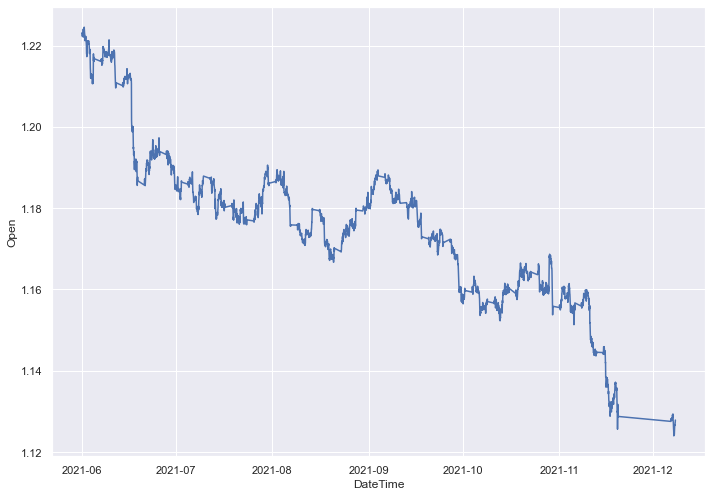

In [7]:
sns.lineplot(data=df, x="DateTime", y="Open")

In [10]:
data = get_last_n(df, 20)

# Test

In [11]:
# Set env
env = TradeEnv(data)

# Variable para guardar nuestras acciones
actions_taken = []

# MODELO ACTUAL
test_reward = 0

state = np.array(env.reset()).reshape((1, env._get_obs().shape[0]))

episode_reward = 0

for step in range(env.n_step):
    
    action = np.argmax(reconstructed_model.predict(state)[0])
    state_next, reward, done, _ = env.step(action)
    state_next = np.array(state_next).reshape((1, env._get_obs().shape[0]))
    
    actions_taken.append(action)
    test_reward += reward 
    
    if done:
        break

# Acciones tomadas

In [12]:
print(actions_taken)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

# Reward acumulado obtenido

In [13]:
print(test_reward)

0
